In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display


# Options

In [2]:
regions = ['SEA','Indo','Malay','Cambod','Viet','all_countries']
month = 'Jan' #options are Jan, Apr, Jul, Oct
time = '2016010'
#compare_2x = True #True allows for comparison to the 2x simulation to see the performance of the GF; False just creates a new GF
#global_mean = True #False turns on a spatially explicit version with lat and lon; True turns on a global weighted mean
length_simulation = 60 #days
diagnostic = 'SpeciesConc'


## Import data

In [3]:
dict_conc = {}
dict_emis = {}
for r in regions:
    print(r)
    #15x step for GF
    dict_conc[r] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/{r}/{month}/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords')
    #doubled run
    dict_conc[r + '_2x'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x/{r}/{month}/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords')
    #15x step for GF
    dict_emis[r] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/{r}/{month}/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
    #doubled run
    dict_emis[r + '_2x'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_2x/{r}/{month}/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')



dict_conc['base'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords', engine = 'netcdf4')
dict_emis['base'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords', engine = 'netcdf4')

SEA
Indo
Malay
Cambod
Viet
all_countries


In [4]:
dict_conc['all_countries_summed'] = dict_conc['Indo'] + dict_conc['Malay'] + dict_conc['Viet'] + dict_conc['Cambod']

In [5]:
ds_conc = xr.concat([dict_conc[r] for r in dict_conc.keys()], pd.Index([r for r in dict_conc.keys()], name='run'))
ds_emis = xr.concat([dict_emis[r] for r in dict_emis.keys()], pd.Index([r for r in dict_emis.keys()], name='run'))

In [6]:
ds_conc['BC_total'] = ds_conc['SpeciesConc_BCPI'] + ds_conc['SpeciesConc_BCPO']
utils.combine_BC(ds_emis)

In [7]:
ds_emis = utils.fix_area_ij_latlon(ds_emis)
ds_conc= utils.fix_area_ij_latlon(ds_conc)

In [10]:
ds_conc['lev']

<xarray.DataArray 'lev' (lev: 72)>
array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.,
       71., 72.])
Coordinates:
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0
Attributes:
    coordinate:     eta
    long_name:      vertical level
    positive:       up
    standard_name:  model_layer
    units:          layer

## Add height to data

In [9]:
height = pd.read_excel('gc_72_estimate.xlsx', index_col = 0)

In [10]:
height = height.reindex(index=height.index[::-1])

In [11]:
height_ds = height.diff().dropna().to_xarray().rename({'L':'lev'})
height_ds = height_ds.rename({'Altitude (km)':'dz'}) 
height_ds['dz']*=1e3 #convert to meters
height_ds['dz'].attrs = {'units':'m'}

In [12]:
#ds_emis = xr.merge([ds_emis, height_ds], join = 'inner')
ds_conc = xr.merge([ds_conc, height_ds], join = 'inner')

In [13]:
sec_day = 86400

## Define our Conc Difference and Initial Forcing

In [14]:
poll_name = 'BC_total'
dt = 1 #day

In [15]:
ds_emis = ds_emis.isel(lev = -1) #select surface since we only have surface emissions

In [52]:
regions = ds_conc.run.values[:-1]

In [17]:
#shift our time so that it is halfway through the day to represent the daily mean
utils.switch_conc_time(ds_conc)

In [53]:
#calculate the dc/dt
dict_dc_dt = {}
dict_dc_dt_gmean = {}
f0 = {}
for r in regions:
    #change in concentration over time
    dict_dc_dt_gmean[r] = utils.calc_δc_δt_mean(ds_conc, poll_name, r, 'base')
    dict_dc_dt_gmean[r] = dict_dc_dt_gmean[r].assign_coords(time = np.arange(.5,len(dict_dc_dt_gmean[r]['time'])+.5))

    dict_dc_dt[r] = utils.calc_δc_δt(ds_conc, poll_name, r, 'base')
    dict_dc_dt[r] = dict_dc_dt[r].assign_coords(time = np.arange(.5,len(dict_dc_dt[r]['time'])+.5))
        
    #f0 calculation    
    f0[r] = (ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = r) - 
        ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = 'base')).values.mean() #look into this a bit more regarding the t = 0

In [54]:
#create the dataset of our dc/dt
dc_dt = xr.concat([dict_dc_dt[r] for r in dict_dc_dt.keys()], pd.Index([r for r in dict_dc_dt.keys()], name='run'))
dc_dt_gmean = xr.concat([dict_dc_dt_gmean[r] for r in dict_dc_dt_gmean.keys()], pd.Index([r for r in dict_dc_dt_gmean.keys()], name='run'))
dc_dt = dc_dt.rename({'time':'s'})
dc_dt_gmean = dc_dt_gmean.rename({'time':'s'})

In [56]:
#calculate the Green's function as dc/dt/f0
G_dict = {}
G_dict_gmean = {}
for r in regions:
    G_dict[r] = dc_dt.sel(run = r)/f0[r]#[:,np.newaxis, np.newaxis, np.newaxis]
    G_dict_gmean[r] = dc_dt_gmean.sel(run = r)/f0[r]

G_dict['all_countries_summed'] = ((dc_dt.sel(run = 'Viet') + dc_dt.sel(run = 'Indo') + dc_dt.sel(run = 'Malay') + dc_dt.sel(run = 'Cambod'))/
                                 (f0['Viet'] + f0['Indo'] + f0['Malay'] + f0['Cambod']))#[:,np.newaxis, np.newaxis, np.newaxis])
G_dict_gmean['all_countries_summed'] = ((dc_dt_gmean.sel(run = 'Viet') + dc_dt_gmean.sel(run = 'Indo') + dc_dt_gmean.sel(run = 'Malay') + dc_dt_gmean.sel(run = 'Cambod'))/
                                 (f0['Viet'] + f0['Indo'] + f0['Malay'] + f0['Cambod']))


In [57]:
regions = np.append(regions, ['all_countries_summed'])

In [58]:
#convert to datasets, calculate mean GF
G = xr.concat([G_dict[r] for r in G_dict.keys()], pd.Index([r for r in G_dict.keys()], name='run'))
G_mean = xr.concat([G_dict_gmean[r] for r in G_dict_gmean.keys()], pd.Index([r for r in G_dict_gmean.keys()], name='run'))


## Save out the Green's function

In [82]:
G.to_netcdf(f'Outputs/G_all_countries_{month}_{poll_name}.nc4')

## Location Average test 

In [59]:
ds_emis = ds_emis.rename({'time':'tp'})

ValueError: cannot rename 'time' because it is not a variable or dimension in this dataset

In [60]:
ds_emis = ds_emis.assign_coords(tp = np.arange(0,len(ds_emis['tp'])))

In [61]:
ds_emis_gmean = {}
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    ds_emis_gmean[r] = (ds_emis.sel(run = r + '_2x')-
                 ds_emis.sel(run = 'base'))['EmisBC_Total'].weighted(
    (ds_emis['area'].fillna(0)).sel(run = 'base')).sum(dim = ['lat','lon']).compute()


In [62]:
G_loc = G.sel(lat = 25, lon = 114, method = 'nearest').isel(lev = 0)

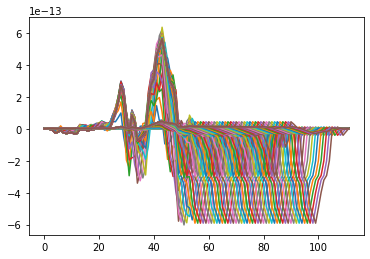

In [63]:
out_mean = {}
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    out_mean[r] = utils.convolve_global_mean(G_loc.sel(run = r).compute(), ds_emis_gmean[r], dt = dt)

## Global Mean Test

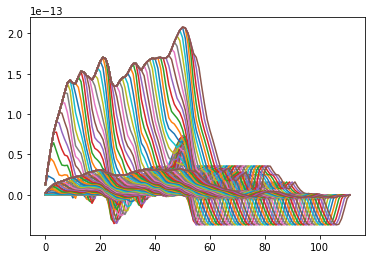

In [64]:
out_gmean = {}
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    out_gmean[r] = utils.convolve_global_mean(G_mean.sel(run = r).compute(), ds_emis_gmean[r], dt = dt)

# Plots

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


KeyboardInterrupt: 

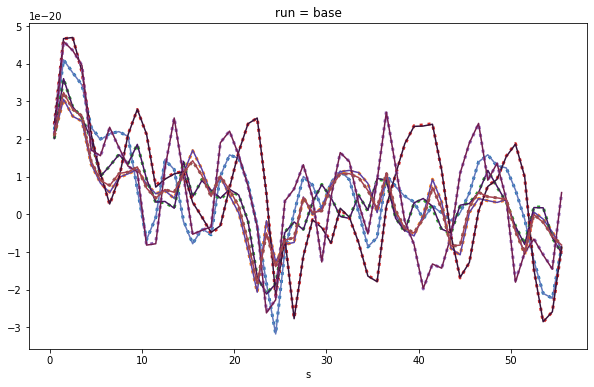

In [28]:
fig, ax = plt.subplots(figsize = [10,6])
color = iter(cm.twilight(np.linspace(.2, .9, 16)))
for r in regions:
    c = next(color)
    if '2x' in r:
        G_mean.sel(run = r).plot(label = r, linestyle = 'solid', c= c)
    else:
        G_mean.sel(run = r).plot(label = r, linestyle = 'dotted', linewidth = 3)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title('')
#plt.savefig('figures/G.png', dpi = 200, bbox_inches = 'tight')

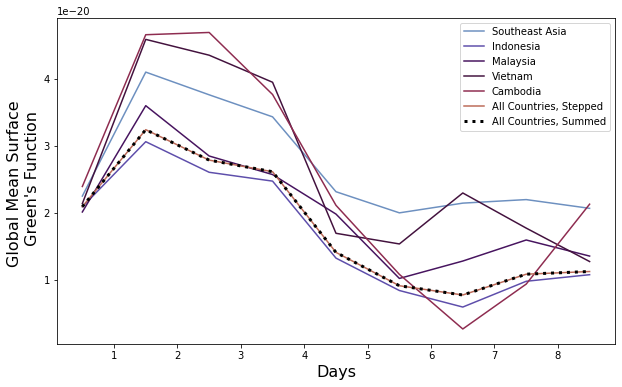

In [37]:

fig, ax = plt.subplots(figsize = [10,6])
color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries', 'all_countries_summed']:
    c = next(color)
    if r != 'all_countries_summed':
        G_mean.sel(run = r).plot(label = names_dict[r], linestyle = 'solid', c= c)
    else:
        G_mean.sel(run = r).plot(label = 'All Countries, Summed', linestyle = 'dotted', c= 'black', linewidth = 3)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title('')
plt.savefig('figures/G_spatial_comp.png', dpi = 200, bbox_inches = 'tight')

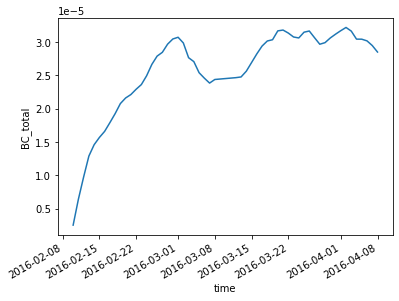

In [113]:
r = 'all_countries'
((utils.global_w_mean(ds_conc.sel(run = r + '_2x').fillna(0), poll_name)-utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name))*1e9).plot()

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,4])

color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo']:
    c = next(color)
    ax1.plot((utils.global_w_mean(ds_conc.sel(run = r + '_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name))*1e9, color = c)
    ax1.plot(out_gmean[r]*1e9, label = utils.names_dict[r], linestyle = ':', linewidth = 3, color = c)

#ax1.legend(fontsize = 12)
ax1.set_ylabel('Global Mean Concentration (ppt)', fontsize = 18)
ax1.set_xlabel('Days', fontsize = 18)
ax1.set_xlim(0,60)


color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo']:
    c = next(color)
    ax2.plot((ds_conc.sel(run = r + '_2x')-ds_conc.sel(run = 'base')).sel(lat = 25, lon = 114, method = 'nearest').fillna(0).isel(lev = 0)['BC_total']*1e9, 
             color = c)
    ax2.plot(out_mean[r]*1e9, label = utils.names_dict[r], linestyle = ':', linewidth = 3, color = c)

#ax2.legend(fontsize = 12)
ax2.set_xlim([0,50])
ax2.set_xlim(0,60)
ax2.set_ylabel('Location Specific Concentration (ppt)', fontsize = 18)
ax2.set_xlabel('Days', fontsize = 18)
ax2.set_yscale("log")  


color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo']:
    c = next(color)
    if r != 'all_countries_summed':
        G_mean.sel(run = r).plot(ax = ax3, label = utils.names_dict[r], linestyle = 'solid', c= c)
    else:
        G_mean.sel(run = r).plot(ax = ax3, label = 'All Countries, Summed', linestyle = 'dotted', c= 'black', linewidth = 3)
ax3.legend()
ax3.set_xlabel('Days', fontsize = 16)
ax3.set_ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
ax3.set_title('')
ax3.set_xlim(0,60)

plt.tight_layout()

#plt.savefig('figures/loc_avg_jan.png', bbox_inches = 'tight', dpi = 200)

(1.5e-13, 2e-13)

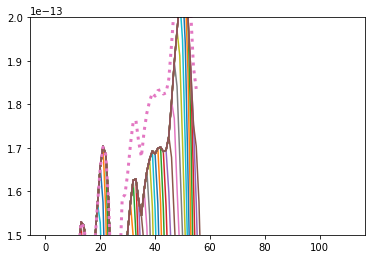

In [37]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][0].values, dt = dt)
plt.plot((utils.global_w_mean(ds_conc.sel(run = 'SEA_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)), linestyle = ':', linewidth = 3)
plt.ylim(1.5e-13,2.0e-13)

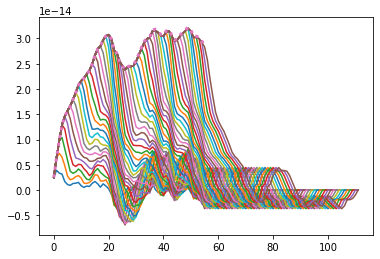

In [43]:
utils.convolve_global_mean(G_mean.sel(run = 'all_countries').compute(), ds_emis_gmean['all_countries'], dt = dt)
plt.plot((utils.global_w_mean(ds_conc.sel(run = 'all_countries_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)), linestyle = ':', linewidth = 3)

<xarray.DataArray (s: 112)>
array([ 1.28277446e-14,  3.62223337e-14,  5.76822234e-14,  7.72638665e-14,
        9.04643790e-14,  1.01862593e-13,  1.14089699e-13,  1.26618541e-13,
        1.38402173e-13,  1.42242655e-13,  1.38418652e-13,  1.37927428e-13,
        1.46135771e-13,  1.52956677e-13,  1.52094363e-13,  1.47661461e-13,
        1.45475822e-13,  1.42392296e-13,  1.48133953e-13,  1.57114440e-13,
        1.65617190e-13,  1.70329357e-13,  1.68536843e-13,  1.58140141e-13,
        1.40067006e-13,  1.34660863e-13,  1.34872101e-13,  1.40579591e-13,
        1.45041224e-13,  1.45954198e-13,  1.50750210e-13,  1.57305843e-13,
        1.62538884e-13,  1.62828843e-13,  1.57892070e-13,  1.54418846e-13,
        1.60322297e-13,  1.64601855e-13,  1.67393729e-13,  1.69275697e-13,
        1.68593336e-13,  1.69894659e-13,  1.70153695e-13,  1.69130962e-13,
        1.69414240e-13,  1.72648825e-13,  1.80610387e-13,  1.89610602e-13,
        1.96939499e-13,  2.03977906e-13,  2.07675600e-13,  2.06910632e-13,
        1.99979738e-13,  1.88040097e-13,  1.75333886e-13,  1.70333573e-13,
        1.57506351e-13,  1.34113166e-13,  1.12654318e-13,  9.30734883e-14,
        7.98734737e-14,  6.84759540e-14,  5.62499204e-14,  4.37220778e-14,
        3.19388136e-14,  2.80983037e-14,  3.19218932e-14,  3.24129690e-14,
        2.42051815e-14,  1.73846202e-14,  1.82468641e-14,  2.26795536e-14,
        2.48650375e-14,  2.79481689e-14,  2.22063738e-14,  1.32258848e-14,
        4.72320807e-15,  1.08961076e-17,  1.80306754e-15,  1.21991673e-14,
        3.02716066e-14,  3.56781576e-14,  3.54677266e-14,  2.97609053e-14,
        2.52987499e-14,  2.43843715e-14,  1.95873188e-14,  1.30308713e-14,
        7.79733285e-15,  7.50667998e-15,  1.24423805e-14,  1.59146046e-14,
        1.00107865e-14,  5.73125551e-15,  2.93979473e-15,  1.05797548e-15,
        1.73978071e-15,  4.38113253e-16,  1.79146884e-16,  1.20209319e-15,
        9.18969098e-16, -2.31522116e-15, -1.02766440e-14, -1.92768577e-14,
       -2.66058277e-14, -3.36440897e-14, -3.73414412e-14, -3.65758707e-14,
       -2.96442813e-14, -1.77050484e-14, -4.99964415e-15,  0.00000000e+00])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 103 104 105 106 107 108 109 110 111

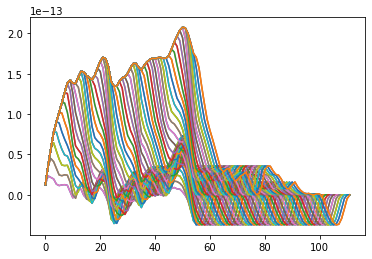

In [125]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][0].values, dt = dt)
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), ds_emis_gmean['SEA'], dt = dt)


<xarray.DataArray (s: 112)>
array([ 1.28277446e-14,  3.62223337e-14,  5.76822234e-14,  7.72638665e-14,
        9.04643790e-14,  1.01862593e-13,  1.14089699e-13,  1.26618541e-13,
        1.38402173e-13,  1.42242655e-13,  1.38418652e-13,  1.37927428e-13,
        1.46135771e-13,  1.52956677e-13,  1.52094363e-13,  1.47661461e-13,
        1.45475822e-13,  1.42392296e-13,  1.48133953e-13,  1.57114440e-13,
        1.65617190e-13,  1.70329357e-13,  1.68536843e-13,  1.58140141e-13,
        1.40067006e-13,  1.34660863e-13,  1.34872101e-13,  1.40579591e-13,
        1.45041224e-13,  1.45954198e-13,  1.50750210e-13,  1.57305843e-13,
        1.62538884e-13,  1.62828843e-13,  1.57892070e-13,  1.54418846e-13,
        1.60322297e-13,  1.64601855e-13,  1.67393729e-13,  1.69275697e-13,
        1.68593336e-13,  1.69894659e-13,  1.70153695e-13,  1.69130962e-13,
        1.69414240e-13,  1.72648825e-13,  1.80610387e-13,  1.89610602e-13,
        1.96939499e-13,  2.03977906e-13,  2.07675600e-13,  2.06910632e-13,
        1.99979738e-13,  1.88040097e-13,  1.75333886e-13,  1.70333573e-13,
        1.57506351e-13,  1.34113166e-13,  1.12654318e-13,  9.30734883e-14,
        7.98734737e-14,  6.84759540e-14,  5.62499204e-14,  4.37220778e-14,
        3.19388136e-14,  2.80983037e-14,  3.19218932e-14,  3.24129690e-14,
        2.42051815e-14,  1.73846202e-14,  1.82468641e-14,  2.26795536e-14,
        2.48650375e-14,  2.79481689e-14,  2.22063738e-14,  1.32258848e-14,
        4.72320807e-15,  1.08961076e-17,  1.80306754e-15,  1.21991673e-14,
        3.02716066e-14,  3.56781576e-14,  3.54677266e-14,  2.97609053e-14,
        2.52987499e-14,  2.43843715e-14,  1.95873188e-14,  1.30308713e-14,
        7.79733285e-15,  7.50667998e-15,  1.24423805e-14,  1.59146046e-14,
        1.00107865e-14,  5.73125551e-15,  2.93979473e-15,  1.05797548e-15,
        1.73978071e-15,  4.38113253e-16,  1.79146884e-16,  1.20209319e-15,
        9.18969098e-16, -2.31522116e-15, -1.02766440e-14, -1.92768577e-14,
       -2.66058277e-14, -3.36440897e-14, -3.73414412e-14, -3.65758707e-14,
       -2.96442813e-14, -1.77050484e-14, -4.99964415e-15,  0.00000000e+00])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 103 104 105 106 107 108 109 110 111

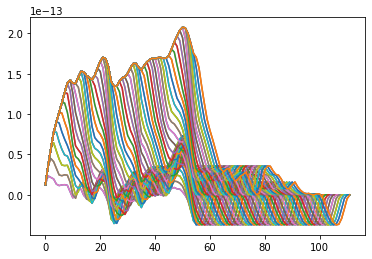

In [124]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][30].values, dt = dt)
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), ds_emis_gmean['SEA'], dt = dt)


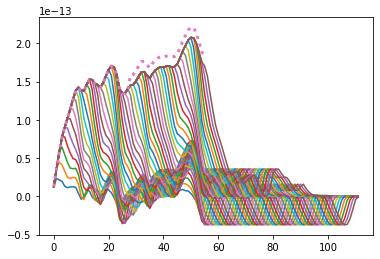

In [127]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][55].values, dt = dt)
plt.plot((utils.global_w_mean(ds_conc.sel(run = 'SEA_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)), linestyle = ':', linewidth = 3)

array([570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 5

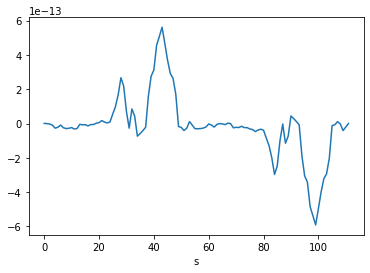

In [35]:
out_mean['SEA'].plot()